In [1]:
show_plots = False

In [2]:
import numpy as np
import scipy.interpolate as intp
import matplotlib.pyplot as plt
from numpy import cos, sin
from mpl_toolkits.mplot3d import axes3d
from colormath.color_objects import sRGBColor, XYZColor
from colormath.color_conversions import convert_color

In [3]:
# get color matching functions
MF = np.genfromtxt("CMF_5nm.csv", delimiter=',')
cmf = MF[:, 1:4]
Norm = sum(cmf)    
abeam = np.ones(cmf.shape[0])
wtpt = cmf.T@abeam

In [4]:
# add purple points
ucmf = [c/np.linalg.norm(c) for c in cmf]
coeffs = np.linspace(0, 1, 30)
c1 = cmf[-1]/np.linalg.norm(cmf[-1])
c0 = cmf[0]/np.linalg.norm(cmf[0])
mixture = []
for c in coeffs:
    mix = c*c0 + (1-c)*c1
    mixture.append(mix/np.linalg.norm(mix))
units = np.concatenate((ucmf, mixture))

In [5]:
# spline from points
I = np.linspace(0, 2*np.pi, len(units))
x_spline = intp.make_interp_spline(I, units[:, 0])
y_spline = intp.make_interp_spline(I, units[:, 1])
z_spline = intp.make_interp_spline(I, units[:, 2])

In [6]:
trials = 1000000

In [7]:
vec = lambda s: np.array([x_spline(s), y_spline(s), z_spline(s)])
input_pts = np.linspace(0, 2*np.pi, trials + 1)
spline_pts = vec(input_pts)

the white point is not on an axis. perhaps we can rotate the axis!?

In [8]:
# want to move [x,y,z] to [0,r,0]
uwtpt = wtpt/np.linalg.norm(wtpt)

In [9]:
# http://scipp.ucsc.edu/~haber/ph216/rotation_12.pdf
def get_rot_matrix(n, t):
    n1,n2,n3 = n[0],n[1],n[2]
    return np.array([
        [cos(t) + n1*n1 * (1 - cos(t)), n1*n2*(1 - cos(t)) - n3*sin(t), n1*n3*(1 - cos(t)) + n2*sin(t)],
        [n1*n2*(1 - cos(t)) + n3*sin(t), cos(t) + n2*n2*(1 - cos(t)), n2*n3*(1 - cos(t)) - n1*sin(t)],
        [n1*n3*(1 - cos(t)) - n2*sin(t), n2*n3*(1 - cos(t)) + n1*sin(t), cos(t) + n3*n3*(1 - cos(t))],
    ])

In [10]:
cross = np.cross(uwtpt, [0,1,0])
theta = np.arccos(np.dot(uwtpt, [0,1,0]))
assert np.allclose(uwtpt, get_rot_matrix(cross/np.linalg.norm(cross), -theta) @ [0,1,0])
assert np.allclose([0,1,0], get_rot_matrix(cross/np.linalg.norm(cross), theta) @ uwtpt)

In [11]:
rot = get_rot_matrix(cross/np.linalg.norm(cross), theta)

In [12]:
# some extra magic to make sure we get the whole angle from [0,2pi)
get_theta = lambda v:  np.sign(v[2])*np.arccos(v[0] / (v[0]**2 + v[2]**2)**0.5) \
     - np.sign(v[2]) * np.pi + np.pi

In [13]:
rotated_spline_pts = rot @ spline_pts

In [14]:
thetas = get_theta(rotated_spline_pts)

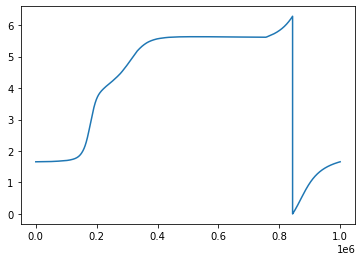

In [15]:
plt.plot(thetas)

Now we have the x,y,z and theta value of each spline pt

In [16]:
# next goal: pick even points across theta

In [17]:
N = 1000
symmetric_thetas = np.arange(N)/N*2*np.pi
# for each t:
#   find the nearest spline point to t
#   find the nearest spline potnt to t+pi
# solve the matrix

In [18]:
# if we need perf boost:
# use https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array

indices = []
complement_indices = []

for t in symmetric_thetas:
    closest_pt = np.argmin(abs(thetas - t))
    tolerance = abs(t -thetas[closest_pt])
    assert tolerance < 1e-3, "delta theta for " + str(t) + ":" +  tolerance
    indices.append(closest_pt)
    
    t_plus_pi = (t + np.pi) % (2*np.pi)
    closest_complement_pt = np.argmin(abs(t_plus_pi - thetas))
    tolerance = abs(t_plus_pi -thetas[closest_complement_pt])
    assert tolerance < 1e-3, "delta theta for " + str(t_plus_pi) + ":" + tolerance
    complement_indices.append(closest_complement_pt)

In [19]:
char_pts = []
for i in range(N):
    vt = rotated_spline_pts[:, indices[i]]
    vt_plus_pi = rotated_spline_pts[:, complement_indices[i]]

    matrix = np.array([
        vt[0:2],
        vt_plus_pi[0:2]
    ]).T

    k, l = np.linalg.inv(matrix) @ [0, np.linalg.norm(wtpt)]

    # check step
    diff = np.linalg.norm(k * vt - (rot @ wtpt - l * vt_plus_pi))
    try:
        assert diff < .01, "norm of difference of k vt and complement vector at theta=" + str(symmetric_thetas[i]) + ":" + diff
    except:
        print('diff for t=' + str(symmetric_thetas[i]) + ' too high, trying again..')
        # maybe the x vector is really small. use z instead.
        matrix = np.array([
            vt[1:3],
            vt_plus_pi[1:3]
        ]).T

        k, l = np.linalg.inv(matrix) @ [np.linalg.norm(wtpt), 0]
        # check step
        diff = np.linalg.norm(k * vt - (rot @ wtpt - l * vt_plus_pi))
        assert diff < .01, "norm of difference of k vt and complement vector at theta=" + str(symmetric_thetas[i]) + ":" + diff

    char_pts.append(k * vt)

diff for t=1.5707963267948966 too high, trying again..
diff for t=4.71238898038469 too high, trying again..


now get the char points in the original space

In [20]:
orig_char_pts = [np.linalg.inv(rot) @ c for c in char_pts]

In [21]:
def clip2rgb(xyz):
    if type(xyz) is not XYZColor:
        xyz = XYZColor(xyz[0], xyz[1], xyz[2])
    crgb = convert_color(xyz, sRGBColor)
    r = crgb.rgb_r
    g = crgb.rgb_g
    b = crgb.rgb_b
    r = r if r > 0 else 0
    g = g if g > 0 else 0
    b = b if b > 0 else 0
    r = r if r < 1 else 1
    g = g if g < 1 else 1
    b = b if b < 1 else 1
    return [r, g, b]

In [22]:
import matplotlib 
if show_plots:
    matplotlib.use('Qt5Agg')
    %matplotlib

In [23]:
if show_plots:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for c in orig_char_pts:
        ax.scatter(c[0], c[1], c[2], color=clip2rgb(c))

    half_pts = int(len(orig_char_pts)/2)
    for i in range(half_pts)[::10]:
        pt1 = orig_char_pts[i]
        pt2 = orig_char_pts[i + half_pts]
        ax.plot((pt1[0], pt2[0]), (pt1[1], pt2[1]), (pt1[2], pt2[2]), alpha=0.3, color='black')

check -- do they intersect at the same point?

a1 - (-0.5)(b1 - a1) = c1 + (0.5)(d1 - c1)
0.5a1 + 0.5b1 = 0.5c1 + 0.5d1

In [24]:
import random
half_pts = int(len(orig_char_pts)/2)
idx1 = random.randint(0, half_pts - 1)
idx2 = random.randint(0, half_pts - 1)
a = orig_char_pts[idx1]
b = orig_char_pts[idx1 + half_pts]
c = orig_char_pts[idx2]
d = orig_char_pts[idx2 + half_pts]

matrix = np.array([
    [d[0]-c[0], b[0] - a[0]],
    [d[1]-c[1], b[1] - a[1]],
])
np.linalg.inv(matrix) @ [a[0] - c[0], a[1] - c[1]]

array([ 0.49999752, -0.50000235])

so the gray point is halfway on the line.

In [25]:
np.allclose((0.5*(a + b)) * 2, wtpt, rtol=1e-04)

True

so the gray point is halfway up the wtpt!

## Now respline, and cut into equal volumes


In [26]:
def volume(a,b,c):
    # https://en.wikipedia.org/wiki/Tetrahedron#Volume
    # black point: (0,0,0)
    # volume: |a * (b x c) | / 6
    return abs(a.dot(np.cross(b, c))) / 6

def get_partition(xspline, yspline, zspline, wtpt, trials, N):
    # 1. split spline into a bunch of tiny points
    vec = lambda s: np.array([xspline(s), yspline(s), zspline(s)])
    input_pts = np.linspace(0, 2*np.pi, trials + 1)
    spline_pts = vec(input_pts)
    # 2. calculate the volume for each wedge
    volumes = [volume(wtpt, spline_pts[:, i], spline_pts[:, i+1]) for i in range(trials)]
    # 3. fitting routine to get the equal partitions
    target = sum(volumes)/N
    new_pts = [0]
    new_volumes = []
    i = 0
    while i < len(volumes):
        v = 0
        while v < target and i < len(volumes):
            v += volumes[i]
            i += 1
        new_pts.append(i)
        new_volumes.append(v)
    return new_pts, new_volumes, spline_pts[:, new_pts]
    

In [27]:
%%time
xvec, yvec, zvec = np.array(orig_char_pts).T
# make the spline periodic 
xvec = np.concatenate((xvec, [xvec[0]]))
yvec = np.concatenate((yvec, [yvec[0]]))
zvec = np.concatenate((zvec, [zvec[0]]))

# fit 3 pre-mensuration splines
I = np.linspace(0, 2*np.pi, len(orig_char_pts)+1)
x_spline = intp.make_interp_spline(I, xvec)
y_spline = intp.make_interp_spline(I, yvec)
z_spline = intp.make_interp_spline(I, zvec)


# get equal spline pts
_, _, equal_spline_pts = get_partition(x_spline, y_spline, z_spline, wtpt, trials=int(5e5), N=100)


CPU times: user 16 s, sys: 162 ms, total: 16.2 s
Wall time: 16 s


In [28]:
if show_plots:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for s in equal_spline_pts.T:
        ax.scatter(s[0], s[1], s[2], color=clip2rgb(s))

Now we got evenly spaced char colors! even on volume.

In [29]:
equal_thetas = get_theta(rot @ equal_spline_pts)

# Optimal color solid

In [30]:
def bump(I, x0, xf):
    out = np.zeros(len(I))
    if x0 < xf:
        out[x0:xf] = 1
    elif x0 > xf:
        out[x0:] = 1
        out[0:xf] = 1
    return out

def Optimal(wl1, wl2, cmf, abeam, normalized=False):
    """
    Optimal windowing function with wrapping
    """
    abeam_matrix = np.diag(abeam)
    X =  np.dot(abeam_matrix@cmf[:,0], bump(cmf, wl1, wl2))
    Y =  np.dot(abeam_matrix@cmf[:,1], bump(cmf, wl1, wl2))
    Z =  np.dot(abeam_matrix@cmf[:,2], bump(cmf, wl1, wl2))
    XYZ = [X, Y, Z]
    if normalized:
        Norm = sum(cmf)
        return (XYZ[0]/Norm[0], XYZ[1]/Norm[1], XYZ[2]/Norm[2])
    else:
        return (XYZ[0], XYZ[1], XYZ[2])

pick:
* number of theta divisions (equal volume ones work fine)
* number of axial divisions

for each axial division:
* minimize distance to each point

In [31]:
L = cmf.shape[0]

optimal_color_grid = []
for i in range(0, L, 1):
    v = []
    for j in range(0, L, 1):
        O = Optimal(i, (i+j)%L, cmf, abeam)
        v.append(O)
    optimal_color_grid.append(v)
optimal_color_grid = np.array(optimal_color_grid)

In [32]:
optimal_color_grid.T[0].shape

(89, 89)

In [33]:
from scipy.interpolate import RectBivariateSpline as Rspl

In [34]:
np.linspace(0, 1, 89).shape

(89,)

In [35]:
I = np.linspace(0, 1, 89)
spx = Rspl(I, I, optimal_color_grid.T[0])
spy = Rspl(I, I, optimal_color_grid.T[1])
spz = Rspl(I, I, optimal_color_grid.T[2])

In [36]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# for i in np.linspace(0.5, 0.6, 10):
#     for j in np.linspace(0.5, 0.6, 10):
#         ax.scatter(spx(i,j), spy(i,j), spz(i,j), color='gray')


In [37]:
def opt_solid_spline(i,j):
    return (spx(i,j)[0][0], spy(i,j)[0][0], spz(i,j)[0][0])

def distance(coords, v1, v2):
#     v1 = args[0]
#     v2 = args[1]
    if coords[0] < 0 or coords[1] < 0 or coords[0] > 1 or coords[1] > 1:
        return 1000
    s = opt_solid_spline(*coords)
    y_rot_v1 = (rot @ v1)[1]
    y_rot_v2 = (rot @ v2)[1]
    if ((rot @ s)[1] > max(y_rot_v1, y_rot_v2)) or ((rot @ s)[1] < min(y_rot_v1, y_rot_v2)):
        return 10000
    return alpha(s, v1, v2)

In [38]:
# do i need to make a mesh?
N = 1001
r = np.linspace(0, 1, N)
mesh = np.zeros((N, N, 2))
for i in range(N):
    mesh[i, :, 0] = r
for j in range(N):
    mesh[:, j, 1] = r

In [39]:
v = lambda s: np.array([spx(*s)[0][0], spy(*s)[0][0], spz(*s)[0][0]])

In [40]:
%%time
opt_solid = np.zeros((N, N, 3))
for idx, i in enumerate(r):
    for jdx, j in enumerate(r):
        opt_solid[idx, jdx] = v((i,j))

CPU times: user 10.8 s, sys: 48 ms, total: 10.8 s
Wall time: 10.8 s


In [41]:
def calc_optimal_pt_mesh(opt_solid, v1, v2):
#     denom = np.linalg.norm(v2 - v1)
    resh = opt_solid.reshape(-1, 3)
    ll = np.min((v1, v2), axis=0)
    ur = np.max((v1, v2), axis=0)
    resh = resh[np.all((ll <= resh) & (resh <= ur), axis=1)]
    mv1 = resh - v1
    mv2 = resh - v2
    results = np.linalg.norm(np.cross(mv1, mv2), axis=1)
    return np.argmin(results), resh[np.argmin(results)], np.min(results)

In [42]:
# now calculate all lines to every axial point

In [43]:
num_axial = 15
axial_points = np.array([i*wtpt for i in np.linspace(0, 1, num_axial)])
print(len(axial_points))

15


In [44]:
spline_line_pts = equal_spline_pts[:, :-1:4].T
print(spline_line_pts.shape[0])

25


In [45]:
# def alpha(s, v1, v2):
#     return np.linalg.norm(np.cross(s - v1, s-v2)) / np.linalg.norm(v2 - v1)

In [46]:
# from scipy.optimize import minimize

In [47]:
%%time
# vectorizing this might be a good idea
best_optimal_pts = np.zeros((len(spline_line_pts), len(axial_points), 3))
for i1, v1 in enumerate(spline_line_pts):
    for i2, v2 in enumerate(axial_points):
#         alphas = [alpha(s, v1, v2)  for s in optimal_color_grid]
        c = calc_optimal_pt_mesh(opt_solid, v1, v2)
        best_optimal_pts[i1][i2] = c[1]

CPU times: user 15.1 s, sys: 12.1 ms, total: 15.1 s
Wall time: 15.1 s


In [48]:
# def calc_best_optimal_pt(v1, v2, trials = 20):
#     min_tol = 100000
#     pts = []
#     for _ in range(trials):
#         result = minimize(distance, (random.random(), random.random()), args=(v1, v2), method='Nelder-Mead', tol=1e-5)
#         if result.fun < min_tol:
#             min_tol = result.fun
#             pts = result.x
#     print(min_tol)
# #     assert min_tol < 1e-3, min_tol
#     return opt_solid_spline(*pts)

In [49]:
# best_optimal_pts = np.zeros((len(spline_line_pts), len(axial_points), 3))
# for i1, v1 in enumerate(spline_line_pts):
#     for i2, v2 in enumerate(axial_points):
#          best_optimal_pts[i1][i2] = calc_best_optimal_pt(v1, v2)

In [50]:
if show_plots:
    colors = np.array(['green', 'orange', 'blue', 'black', 'purple', 'red'])
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot((0,wtpt[0]),(0,wtpt[1]), (0,wtpt[2]), color='gray')
#     for c in best_optimal_pts.reshape(-1, 3):
#         ax.scatter(c[0], c[1], c[2], color='black')
#     for s in equal_spline_pts.T:
#         ax.scatter(s[0], s[1], s[2], color=clip2rgb(s))

    Norm = sum(cmf)    
    for i1, s in enumerate(spline_line_pts):
        for i2, a in enumerate(axial_points):
#             color = colors[(i2) % len(colors)]
    #         ax.plot((s[0], a[0]), (s[1], a[1]), (s[2], a[2]), color=color)
            c = best_optimal_pts[i1, i2]
            d = (c[0]/Norm[0], c[1]/Norm[1], c[2]/Norm[2])
            ax.scatter(c[0], c[1], c[2], color=clip2rgb(d))


# map to sphere
assuming we map a sphere's vector to the closest vector on the optimal color solid:

In [51]:
if show_plots:
    colors = np.array(['green', 'orange', 'blue', 'black', 'purple', 'red'])
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    r = rot@wtpt / np.linalg.norm(wtpt)
    ax.plot((0,r[0]),(0,r[1]), (0,r[2]), color='gray')
#     for c in best_optimal_pts.reshape(-1, 3):
#         ax.scatter(c[0], c[1], c[2], color='black')
#     for s in equal_spline_pts.T:
#         ax.scatter(s[0], s[1], s[2], color=clip2rgb(s))

#     b = np.array([rot @ i for i in best_optimal_pts.reshape(-1, 3)])
    for i1, s in enumerate(spline_line_pts):
        for i2, a in enumerate(axial_points):
#             color = colors[(i2) % len(colors)]
    #         ax.plot((s[0], a[0]), (s[1], a[1]), (s[2], a[2]), color=color)
            c = best_optimal_pts[i1, i2] 
            d = (c[0]/Norm[0], c[1]/Norm[1], c[2]/Norm[2])
            ax.scatter(*(rot @ c)/ np.linalg.norm(wtpt), color=clip2rgb(d))


In [52]:
# go from xyz vector to vector in optimal color space
# wtpt should go to 001, black point to 00(-1)

In [53]:
# rot around x, from y to z (pi/2)
rotyz = np.array([
    [1,0,0],
    [0,0,-1],
    [0,1,0]
])

In [54]:
assert np.allclose(rotyz @ [0,1,0], [0,0,1])
assert np.allclose(rotyz @ [0,0,1], [0,-1,0])

In [55]:
def convert(v):
    return rotyz @ (2*(rot @ v / np.linalg.norm(wtpt))) - [0,0,1]

def get_color_from_opt(c):
    d = (c[0]/Norm[0], c[1]/Norm[1], c[2]/Norm[2])
    return clip2rgb(d)

In [56]:
optimal_pts_for_sphere = [convert(b) for b in best_optimal_pts.reshape(-1,3)]
vectors_for_sphere = [o/np.linalg.norm(o) for o in optimal_pts_for_sphere]

In [57]:
def find_closest_opt_color(xyz):
    u = xyz/np.linalg.norm(xyz)
    dots = [v.dot(u) for v in vectors_for_sphere]
    m = np.argmax(dots)
    b = best_optimal_pts.reshape(-1, 3)[m]
    return np.array(get_color_from_opt(b))

In [58]:
if show_plots:
    xs = np.random.random(10)
    ys = np.random.random(10)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    for x in xs:
        for y in ys:
            zsq = (1-x**2-y**2)
            if zsq >= 0:
                for f in [-1,1]:
                    for g in [-1,1]:
                        for h in [-1,1]:
                            c = [f*x,g*y,h*zsq**0.5]
                            ax.scatter(c[0], c[1], c[2], color=find_closest_opt_color(c))